In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated timeseries' )

%load_ext autoreload
%autoreload 2

In [2]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [4]:
bands=['nbar_red', 'nbar_green', 'nbar_blue']
# bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1986', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
}

# # Landsat upscaled res
# query = {
#     'geopolygon': geopolygon,
#     'time': ('1986', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-15, 15),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

# # Sentinel-2 10m
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': ('1990', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

ds_ls = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            's2a_ard_granule', 's2a_ard_granule'
                          ],
                 min_gooddata=0.90,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35363 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:41500 Dashboard: /proxy/35363/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


../../Scripts/dea_datahandling.py:286: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 141 out of 1008 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 141 time steps as a dask array


In [6]:
ds_ls = tidal_tag(ds_ls, 
# #                   tidepost_lat=-15.114712, 
#                   tidepost_lon=129.631629
                 )
ds_ls = ds_ls.sel(time = ds_ls.tide_height < 0.5)
ds_ls = ds_ls.compute()
ds_ls

Setting tide modelling location from dataset centroid: 146.60, -38.77


<xarray.Dataset>
Dimensions:      (time: 120, x: 948, y: 710)
Coordinates:
  * time         (time) datetime64[ns] 1987-12-30T23:26:28.765039 ... 2020-07...
  * x            (x) float64 4.512e+05 4.512e+05 ... 4.796e+05 4.796e+05
    spatial_ref  int32 32655
  * y            (y) float64 -4.281e+06 -4.281e+06 ... -4.302e+06 -4.302e+06
Data variables:
    nbar_red     (time, y, x) float32 906.0 906.0 877.0 ... 148.0 156.0 155.0
    nbar_green   (time, y, x) float32 807.0 807.0 807.0 ... 258.0 267.0 270.0
    nbar_blue    (time, y, x) float32 488.0 504.0 488.0 ... 387.0 391.0 416.0
    tide_height  (time) float64 0.37 0.422 -0.306 -0.042 ... -0.215 -0.13 0.377
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref

In [7]:
ds_rolling = ds_ls.rolling(time=20, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values,
                            axes=(1, 2, 0))
print(ds_rolling)

<xarray.Dataset>
Dimensions:      (time: 120, x: 948, y: 710)
Coordinates:
  * time         (time) datetime64[ns] 1987-12-30T23:26:28.765039 ... 2020-07...
  * x            (x) float64 4.512e+05 4.512e+05 ... 4.796e+05 4.796e+05
    spatial_ref  int32 32655
  * y            (y) float64 -4.281e+06 -4.281e+06 ... -4.302e+06 -4.302e+06
Data variables:
    nbar_red     (time, y, x) float32 532.5 523.5 527.5 566.5 ... 77.0 89.0 63.0
    nbar_green   (time, y, x) float32 663.0 666.0 669.5 ... 162.0 166.0 165.0
    nbar_blue    (time, y, x) float32 302.0 302.0 317.0 ... 314.0 324.0 323.0
    tide_height  (time) float64 0.1115 0.064 0.011 -0.042 ... 0.101 0.069 0.037


## Standard animation

Exporting animation to animation.mp4


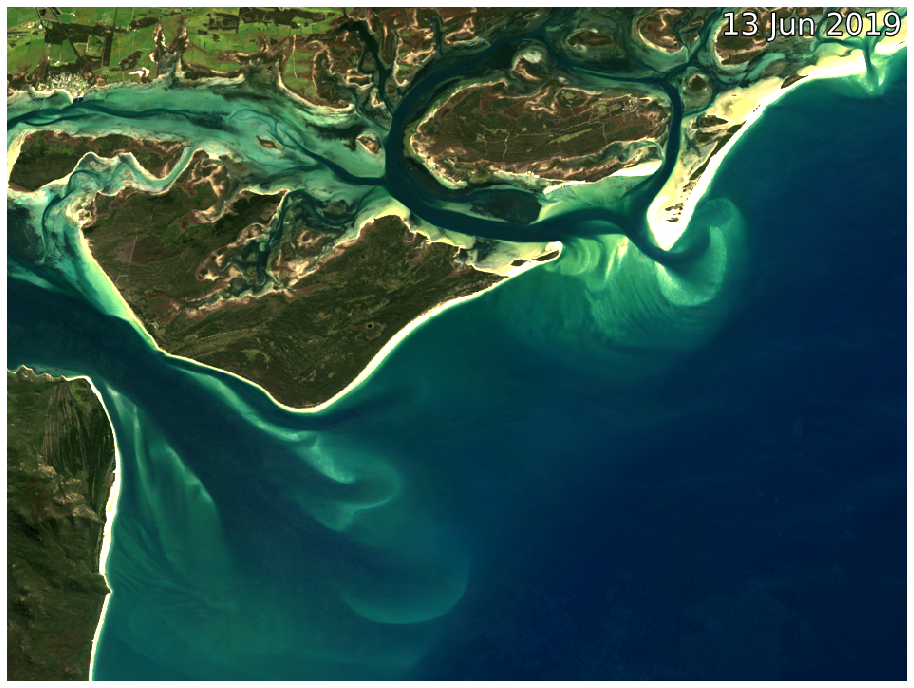

In [9]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.5,
              rescale_intensity,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.3),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.5, gain=0.5),
             ]
funcs_list = None

xr_animation(output_path='animation.mp4',
             ds=ds_rolling.isel(time=slice(5, -5)),
             show_text='',
             bands=bands,
             interval=60,
             width_pixels=900,
             percentile_stretch=(0.02, 0.98),
             image_proc_funcs=funcs_list,
#              show_date=False,
             annotation_kwargs={'fontsize': 30},
            ) 

## DEA CoastLines data

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://nonprod.geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

## Run animation

In [ ]:
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))



In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.5,
              rescale_intensity,
              hue_sat_val,
#               lambda x: unsharp_mask(x, radius=50, amount=0.5),
#               lambda x: unsharp_mask(x, radius=5, amount=0.3),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.5, gain=0.5),
             ]
funcs_list = None

xr_animation(output_path='deacoastlines_animation_8.mp4',
             ds=ds_rolling.isel(time=slice(5, -5)),
             show_text='',
             bands=bands,
             interval=60,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date=False,
             annotation_kwargs={'fontsize': 30},
#              show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2},
#              imshow_kwargs={'vmin': -0.3, 'vmax': 0.5},
#              limit=2,
            ) 

In [ ]:
import geopandas as gpd

# Specify bounding box
ymax, xmin = -33.6507, 115.2790
ymin, xmax = -33.6585, 115.3013

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&srsName=EPSG%3A3577&' \
                       f'maxFeatures=1000&bbox={ymin},{xmin},{ymax},{xmax}'
deacl_statistics_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines_statistics&' \
                       'srsName=EPSG%3A3577&maxFeatures=1000&' \
                       f'bbox={ymin},{xmin},{ymax},{xmax}'

# Load DEA CoastLines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'